In [11]:
import pandas as pd
from statsmodels.tsa.ardl import ARDL, ardl_select_order
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Load your dataset
df = pd.read_excel(r"C:\Users\Aryan Pandey\Desktop\New folder (2)\Paper\Data-Poverty,GCF,GDP.xlsx")
df.set_index('Year', inplace=True)  # if 'year' is your time index

df['gdp_growth'] = df['Rural GDP (In Rs. Crore)'].pct_change() * 100


df['d_gcf'] = df['Rural Capital Formation (In Rs. Crore)'].diff()

# Drop rows with any NaN values (from differencing)
df = df.dropna()


# Check stationarity (ADF test)
print(adfuller(df['HCR (%)']))
print(adfuller(df['d_gcf']))
print(adfuller(df['gdp_growth']))


(np.float64(-0.7885038971912379), np.float64(0.8224756587196826), 1, 68, {'1%': np.float64(-3.530398990560757), '5%': np.float64(-2.9050874099328317), '10%': np.float64(-2.5900010121107266)}, np.float64(290.9449697275665))
(np.float64(-9.192490397103152), np.float64(2.104965986030683e-15), 0, 69, {'1%': np.float64(-3.528889992207215), '5%': np.float64(-2.9044395987933362), '10%': np.float64(-2.589655654274312)}, np.float64(1283.8878398028276))
(np.float64(-6.050962794681899), np.float64(1.2779318314369534e-07), 4, 65, {'1%': np.float64(-3.5352168748293127), '5%': np.float64(-2.9071540828402367), '10%': np.float64(-2.5911025443786984)}, np.float64(350.8003478524595))


In [12]:

df['d_hcr'] = df['HCR (%)'].diff()
adf_result = adfuller(df['d_hcr'].dropna())
print(f"ADF stat (1st diff): {adf_result[0]}, p-value: {adf_result[1]}")


ADF stat (1st diff): -11.590221676166614, p-value: 2.8036141785007223e-21


In [13]:
from statsmodels.tsa.ardl import ARDL

# Step 1: Clean data
df_clean = df[['HCR (%)', 'd_gcf', 'gdp_growth']].dropna()

# Step 2: Provide lag order for exogenous variables only
# 4 lags each for d_gcf and gdp_growth
order = {
    'd_gcf': [1, 2, 3, 4],
    'gdp_growth': [1, 2, 3, 4]
}

# Step 3: Fit ARDL with 4 lags on dependent variable and exog lags as above
model = ARDL(
    endog=df_clean['HCR (%)'],                     # dependent variable
    lags=4,                                        # lags for HCR (%)
    exog=df_clean[['d_gcf', 'gdp_growth']],        # independent variables
    order=order,                                   # exog lag structure
    trend='c'                                      # include constant
).fit()

# Step 4: Show results
print(model.summary())


                              ARDL Model Results                              
Dep. Variable:                HCR (%)   No. Observations:                   70
Model:                  ARDL(4, 4, 4)   Log Likelihood                -162.680
Method:               Conditional MLE   S.D. of innovations              2.846
Date:                Thu, 19 Jun 2025   AIC                            353.359
Time:                        18:14:26   BIC                            384.014
Sample:                             4   HQIC                           365.472
                                   70                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.6026      2.309      1.127      0.265      -2.029       7.234
HCR (%).L1        0.4555      0.112      4.063      0.000       0.231       0.680
HCR (%).L2        0.2694      0.125     

C:\Users\Aryan Pandey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [14]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, normal_ad
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


In [15]:
# Durbin-Watson test (value ~2 is ideal)
print("Durbin-Watson:", durbin_watson(model.resid))

# Ljung-Box Q-test
lb_test = acorr_ljungbox(model.resid, lags=[10], return_df=True)
print(lb_test)


Durbin-Watson: 1.4853246496598487
      lb_stat  lb_pvalue
10  10.191381   0.423866


In [17]:
stat, p = normal_ad(model.resid)
print("Normality test (Anderson-Darling): stat=%.3f, p=%.3f" % (stat, p))


Normality test (Anderson-Darling): stat=1.251, p=0.003


In [19]:
adf_result = adfuller(model.resid)
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")


ADF Statistic: -4.423318985783144, p-value: 0.00026986149761276456


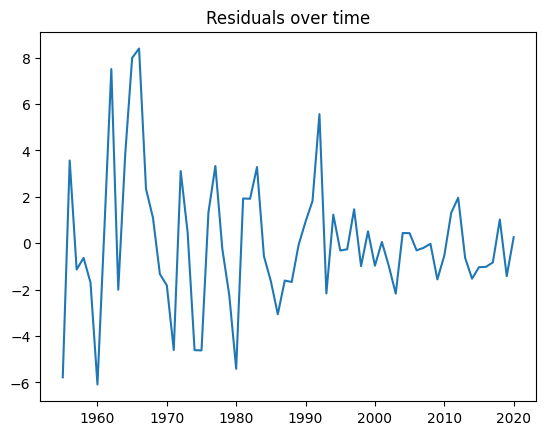

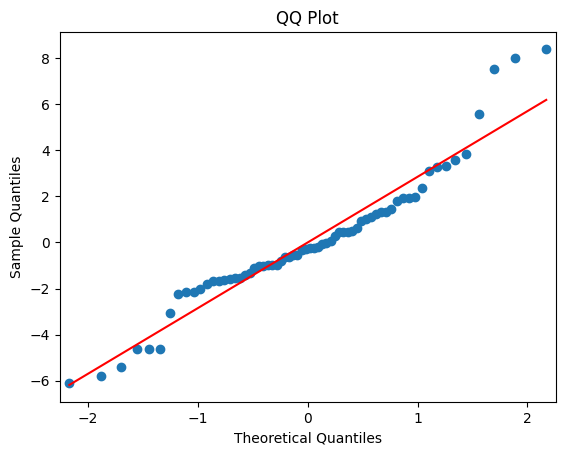

In [20]:
plt.plot(model.resid)
plt.title("Residuals over time")
plt.show()

sm.qqplot(model.resid, line='s')
plt.title("QQ Plot")
plt.show()


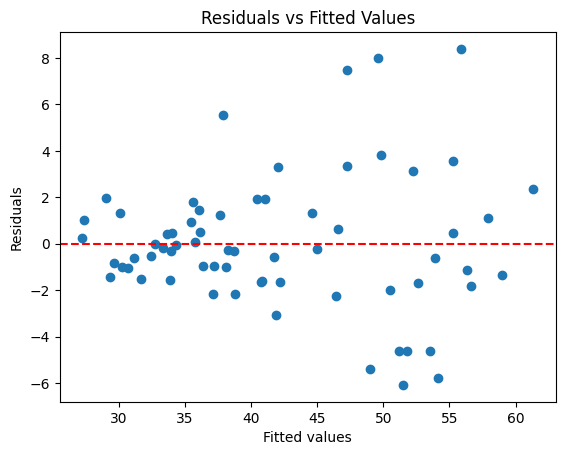

In [28]:
import matplotlib.pyplot as plt

fitted_vals = model.fittedvalues

plt.scatter(fitted_vals, resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()
